In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/dissertationCode"
import os

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score

import pickle as pkl

#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter(log_dir="/content/drive/MyDrive/Colab Notebooks/tensorboard")

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else{}
print(torch.cuda.is_available()) 

True


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 24 17:36:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download data

In [ ]:
training_data = datasets.MNIST(root='..data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='..data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ..data/MNIST/raw/train-images-idx3-ubyte.gz to ..data/MNIST/raw




Extracting ..data/MNIST/raw/train-labels-idx1-ubyte.gz to ..data/MNIST/raw




Extracting ..data/MNIST/raw/t10k-images-idx3-ubyte.gz to ..data/MNIST/raw




Extracting ..data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ..data/MNIST/raw

Processing...


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
train_set, val_set = torch.utils.data.random_split(training_data,[50000,10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, **LOADER_KWARGS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, drop_last=True, ** LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, drop_last=True, **LOADER_KWARGS)

In [ ]:
training_loader = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True, drop_last=True, **LOADER_KWARGS)

In [ ]:
with open(os.path.join(path, "training_loader.pt"), "wb") as f:
  torch.save(training_loader,f)

with open(os.path.join(path, "test_loader.pt"), "wb") as f:
  torch.save(test_loader,f)

# Loading data in drive

In [ ]:
with open(os.path.join(path, "training_loader.pt"), "rb") as f:
  training_loader = torch.load(f)

with open(os.path.join(path, "test_loader.pt"), "rb") as f:
  test_loader = torch.load(f)

# out-of-distribution dataset: notMNIST

In [ ]:
%%time

import shutil
shutil.rmtree("/content/drive/MyDrive/dissertationCode/notMNIST_small")

f1 = "/content/drive/MyDrive/dissertationCode/notMNIST_small.tar.gz"
f1_extract = "/content/drive/MyDrive/dissertationCode/notMNIST_small/"
shutil.unpack_archive(f1, f1_extract)

CPU times: user 8.51 s, sys: 8.33 s, total: 16.8 s
Wall time: 2min 51s


In [ ]:
ls /content/drive/MyDrive/dissertationCode/notMNIST_small/notMNIST_small/A/ | head -10

MDEtMDEtMDAudHRm.png
MDRiXzA4LnR0Zg==.png
MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png
MlJlYmVsc0RldXgtQmxhY2sub3Rm.png
MlRvb24gU2hhZG93LnR0Zg==.png
MlRvb24yIFNoYWRvdy50dGY=.png
MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png
MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png
MTggSG9sZXMgQlJLLnR0Zg==.png
MTh0aENlbnR1cnkudHRm.png


In [ ]:
from PIL import Image
import os

path = "/content/drive/MyDrive/dissertationCode/notMNIST_small/notMNIST_small/"

fnames = []
for root, dir, files in os.walk(path):
  for f in files:
    if f.endswith('.png'):
      fnames.append(os.path.join(root,f))

In [ ]:
print(len(fnames))

18726


In [ ]:
# filter out bad images
def filter_out_bad_images(fnames):
  from matplotlib.pyplot import imread
  from joblib import Parallel, delayed
  import multiprocessing

  def mark_bad_image(f):
    try:
      im = imread(str(f))
    except Exception as e:
      print('could not read:', f, ':', e, '-it\'s ok, skipping')
      return f
  
  # proper filtering
  bad_images = Parallel(n_jobs=4)(delayed(mark_bad_image)(f) for f in tqdm(fnames))
  bad_images = [f for f in bad_images if f!=None]
  print(bad_images)
  return [f for f in fnames if f not in bad_images]


In [ ]:
label_folder = ['A','B','C','D','E','F','G','H','I','J']

In [ ]:
def diff_fname(path):
  fname = []
  for root, dir, files in os.walk(path):
    for f in files:
      if f.endswith('.png'):
        fname.append(os.path.join(root,f))
  fname = filter_out_bad_images(fname)
  return fname


In [ ]:
# sort root of different picture according to their labels
fnames = []
main_path="/content/drive/MyDrive/dissertationCode/notMNIST_small/notMNIST_small/"
for char in label_folder:
  path = os.path.join(main_path,char)
  fname = diff_fname(path)
  fnames.append(fname)

In [ ]:
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class notMNIST(Dataset):
  def __init__(self, img_label, img_dir, transform=None):
    self.img_labels = img_label
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)
  
  def __getitem__(self,idx):
    img_path = self.img_dir[idx]
    image = read_image(img_path)/255.
    label = torch.tensor(self.img_labels[idx], dtype=torch.long)
    #if self.transform:
      #image = self.transform(image)
    
    return image, label

In [ ]:
whole_fnames = fnames[0]
whole_label = np.zeros(len(fnames[0]))
for i in range(1,10):
  print(len(whole_fnames))
  whole_fnames = whole_fnames + fnames[i]
  Label = np.ones(len(fnames[i]))*i
  whole_label = np.concatenate((whole_label, Label), axis=0)


1872
3745
5618
7491
9364
11236
13108
14980
16852


In [ ]:
print(whole_label.size)
print(len(whole_fnames))

18724
18724


In [ ]:
notMNIST_dataset = notMNIST(whole_label, whole_fnames)
notMNIST_dataloader = DataLoader(notMNIST_dataset, batch_size=128, shuffle=True, drop_last=True)
print(notMNIST_dataloader)

Feature batch shape:torch.Size([128, 1, 28, 28])
Label batch shape: torch.Size([128])


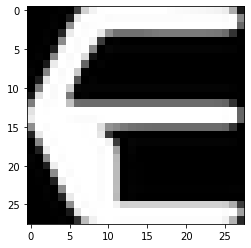

label:4
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.2588, 0.8196,
          0.9569, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 0.9882, 0.9804, 0.9765, 0.9725, 0.9686, 0.9608,
          0.9569, 0.9294, 0.6784, 0.1098],
         [0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.1059, 0.8980, 1.0000,
          0.9961, 0.9961, 0.9843, 0.9882, 0.9882, 0.9882, 0.9882, 0.9882,
          0.9882, 0.9882, 0.9882, 0.9882, 0.9922, 0.9922, 0.9922, 0.9922,
          0.9922, 0.9843, 1.0000, 0.5373],
         [0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.5686, 1.0000, 0.9843,
          0.9922, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 0.9961, 1.0000, 0.4078],
         [0.0000, 0.0000, 0.0078, 0.0000, 0.1490, 0.9255, 1.0000, 0.9922,
          1.0000, 0.9137, 0.5725, 0.4471, 0.4471, 0.4471, 0.4471, 0.4588,
          0.4745, 0.4824, 0.4824, 0.4824, 0.4824,

In [ ]:
train_features, train_labels = next(iter(notMNIST_dataloader))
print(f'Feature batch shape:{train_features.size()}')
print(f'Label batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f'label:{label}')
print(train_features[0])
print(train_labels)

# reset path

In [ ]:
path = "/content/drive/MyDrive/dissertationCode"

# Network

In [ ]:
eps = 1e-20

In [ ]:
class Gaussian:
  def __init__(self, mu, rho):
    self.mu = mu
    self.rho = rho
    self.normal = torch.distributions.Normal(0,1)
  
  @property
  def sigma(self):
    return torch.log1p(torch.exp(self.rho))
  
  def sample(self):
    epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
    return self.mu + self.sigma * epsilon
  
  def log_prob(self, input):
    return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma+eps) - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [ ]:
class GaussianPrior:
  def __init__(self,mu,sigma):
    self.mu = mu
    self.sigma = sigma
  
  def log_prob(self,input):
    return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma) - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [ ]:
class BayesianLinear(nn.Module):
  def __init__(self, n_input, n_output, sigma1, T):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    #self.T = T
    #self.sigma1 = sigma1

    self.w_mu = nn.Parameter(torch.Tensor(n_output,n_input).normal_(0,math.sqrt(2/n_input))) #todo
    self.w_rho = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-5,-4))
    self.w = Gaussian(self.w_mu, self.w_rho)

    self.b_mu = nn.Parameter(torch.Tensor(n_output).normal_(0,math.sqrt(2/n_input)))
    self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-5,-4))
    self.b = Gaussian(self.b_mu, self.b_rho)

    #Prior: Gaussian
    self.w_prior = GaussianPrior(0,sigma1)
    self.b_prior = GaussianPrior(0,sigma1)
    self.log_prior = 0 
    self.log_variational_posterior= 0
    self.KL = 0
  
  def forward(self, input, sample=False):
    if self.training or sample:
      w = self.w.sample()
      b = self.b.sample()
    else:
      w = self.w_mu
      b = self.b_mu
    
    
    self.log_prior = self.w_prior.log_prob(w) + self.b_prior.log_prob(b)
    self.log_variational_posterior = self.w.log_prob(w) + self.b.log_prob(b)
    
    # KL(q||p)
   # n_para = (self.n_input +1) * self.n_output
   # mu_i = torch.cat((self.w_mu.flatten(),self.b_mu)) # mu for all parameters
    #sigma_i = torch.cat((self.w.sigma.flatten(), self.b.sigma)) # sigma for all parameters
    #self.KL = (torch.log(self.sigma1) /self.T - torch.log(sigma_i) + torch.square(mu_i)/(2*torch.square(sigma_i)) + \
    #(1/(2*self.T*self.sigma1*self.sigma1)-1/(2*torch.square(sigma_i))*(torch.square(sigma_i)+torch.square(mu_i)))).sum()
    
    return F.linear(input, w, b)


In [ ]:
class BayesianNetwork(nn.Module):
  def __init__(self, n_units, sigma1, T):
    super().__init__()
    self.l1 = BayesianLinear(28*28, n_units, sigma1, T)
    self.l2 = BayesianLinear(n_units, n_units, sigma1, T)
    self.l3 = BayesianLinear(n_units, 10, sigma1, T)

  def forward(self, x, sample=False):
    x = x.view(-1,28*28)
    x = F.relu(self.l1(x, sample),inplace=False)
    x = F.relu(self.l2(x, sample), inplace=False)
    x = F.softmax(self.l3(x, sample))
    return x
  
  def log_prior(self):
    return self.l1.log_prior + self.l2.log_prior + self.l3.log_prior
  
  def log_variational_posterior(self):
    return self.l1.log_variational_posterior + self.l2.log_variational_posterior + self.l3.log_variational_posterior
  
  def KL_q_p(self):
    return self.l1.KL + self.l2.KL + self.l3.KL

  def free_energy(self, input, target, batch_size, num_batches, n_samples, T):
    outputs = torch.zeros(batch_size, 10).to(DEVICE)
    log_prior = torch.zeros(1).to(DEVICE)
    log_variational_posterior = torch.zeros(1).to(DEVICE)
    negative_log_likelihood = torch.zeros(1).to(DEVICE)
    for i in range(n_samples):
      output = self(input, sample=True)
      outputs +=  output/n_samples
      log_prior += self.log_prior()/n_samples
      log_variational_posterior += self.log_variational_posterior()/n_samples
      negative_log_likelihood += F.nll_loss(torch.log(output+eps), target, size_average=False)/n_samples

    # new target function, not absorb T into prior
    loss = (log_variational_posterior - log_prior / T) + negative_log_likelihood / T * num_batches 
   # loss = self.KL_q_p() + negative_log_likelihood/T *num_batches

    corrects = outputs.argmax(dim=1).eq(target).sum().item()

    return loss, log_prior, log_variational_posterior, negative_log_likelihood, corrects

  
  

In [ ]:
def write_weight_histograms(epoch):
  writer.add_histogram('histogram/w1_mu', net.l1.w_mu, epoch)
  writer.add_histogram('histogram/w1_rho', net.l1.w_rho, epoch)
  writer.add_histogram('histogram/w2_mu', net.l2.w_mu, epoch)
  writer.add_histogram('histogram/w2_rho', net.l2.w_rho, epoch)
  writer.add_histogram('histogram/w3_mu', net.l3.w_mu, epoch)
  writer.add_histogram('histogram/w3_rho', net.l3.w_rho, epoch)

def write_loss_scalars(epoch, loss, accuracy, log_prior, log_variational_posterior, negative_log_likelihood):
  writer.add_scalar('logs/loss', loss, epoch)
  writer.add_scalar('logs/accuracy', accuracy, epoch)
  writer.add_scalar('logs/complexity', log_variational_posterior-log_prior, epoch)
  writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch)


# Train and test


In [ ]:
def train(net, optimizer, epoch, trainLoader, batchSize, nSamples ,T):
  net.train()
  num_batches_train = len(trainLoader)
  
  #if epoch == 0:
   # write_weight_histograms(epoch)
  for batch_idx, (data, target) in enumerate(tqdm(trainLoader)):
    data, target = data.to(DEVICE), target.to(DEVICE)
    
    net.zero_grad()
    loss, log_prior, log_variational_posterior, negative_log_likelihood, corrects = net.free_energy(data, target, batchSize, num_batches_train, nSamples,T)
    loss.backward()
    optimizer.step()

    accuracy = corrects / batchSize
  #write_loss_scalars(epoch, loss, accuracy, log_prior, log_variational_posterior, negative_log_likelihood)
 # write_weight_histograms(epoch)

  return accuracy, loss

In [ ]:
def test(net, testLoader, batchSize, nSamples,T):
  # update ECE
  net.eval()
  accuracy = 0
  n_corrects = 0
  Loss = 0
  num_batches_test = len(testLoader)
  n_test = batchSize * num_batches_test
  outputs = torch.zeros(n_test, 10).to(DEVICE)
  correct = torch.zeros(n_test).to(DEVICE)
  target_all = torch.zeros(n_test).to(DEVICE)
  
  M = 10
  boundary = ((torch.tensor(range(0,M))+1)/10).view(1,-1)
  boundary = boundary.repeat(batchSize, 1).to(DEVICE)
  
  acc_Bm_sum = torch.zeros(M).to(DEVICE)
  conf_Bm_sum = torch.zeros(M).to(DEVICE)
  Bm = torch.zeros(M).to(DEVICE)
  
  with torch.no_grad():
    for i, (data, target) in enumerate(testLoader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      target_all[i*batchSize:batchSize*(i+1)] = target
      for j in range(nSamples):
        output = net(data, sample=True)
        outputs[i*batchSize:batchSize*(i+1), :] += output/nSamples
        Loss +=  F.nll_loss(torch.log(output), target, size_average=False)/nSamples
        # loss is log likelihood
        
      correct[i*batchSize:batchSize*(i+1)] = (outputs[i*batchSize:batchSize*(i+1), :]).argmax(1).eq(target)
      
      otemp =outputs[i*batchSize:batchSize*(i+1), :]
      p_i,_ = otemp.max(dim=1, keepdims=True)
      B = (p_i.le(boundary)*1).argmax(dim=1)
          
      acc_i = otemp.argmax(1).eq(target)
      for m in range(M):
        is_m = B.eq(m)
        Bm[m] += is_m.sum()
        acc_Bm_sum[m] += torch.sum(acc_i * is_m)
        conf_Bm_sum[m] += torch.sum(p_i.flatten() * is_m)

    accuracy = correct.mean()

  ROCAUC = roc_auc_score(target_all.cpu(), outputs.cpu(), multi_class='ovr')
  
  ECE = (acc_Bm_sum - conf_Bm_sum).abs().sum()/(n_test)

  temp = (acc_Bm_sum - conf_Bm_sum)/Bm
  temp[temp!=temp]=0
  MCE,_ = temp.abs().max(0)

  return accuracy, Loss, ECE, MCE, ROCAUC, output

In [ ]:
def test_MoG(net_list, testLoader, batchSize, nSamples,T):
  # update ECE
  for net in net_list:
    net.eval()
  accuracy = 0
  n_corrects = 0
  Loss = 0
  num_batches_test = len(testLoader)
  n_test = batchSize * num_batches_test
  outputs = torch.zeros(n_test, 10).to(DEVICE)
  correct = torch.zeros(n_test).to(DEVICE)
  target_all = torch.zeros(n_test).to(DEVICE)
  n_list = len(net_list)

  M = 10
  boundary = ((torch.tensor(range(0,M))+1)/10).view(1,-1)
  boundary = boundary.repeat(batchSize, 1).to(DEVICE)
  
  acc_Bm_sum = torch.zeros(M).to(DEVICE)
  conf_Bm_sum = torch.zeros(M).to(DEVICE)
  Bm = torch.zeros(M).to(DEVICE)
  
  with torch.no_grad():
    for i, (data, target) in enumerate(testLoader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      target_all[i*batchSize:batchSize*(i+1)] = target
      for k, net in enumerate(net_list):
        for j in range(nSamples):
          output = net(data, sample=True)
          outputs[i*batchSize:batchSize*(i+1), :] += output/(nSamples*n_list)
          Loss +=  F.nll_loss(torch.log(output), target, size_average=False)/(nSamples*n_list)
          # loss is log likelihood
          
      correct[i*batchSize:batchSize*(i+1)] = (outputs[i*batchSize:batchSize*(i+1), :]).argmax(1).eq(target)
      
      otemp = outputs[i*batchSize:batchSize*(i+1), :]
      p_i,_ = otemp.max(dim=1, keepdims=True)
      B = (p_i.le(boundary)*1).argmax(dim=1)
      
      acc_i = otemp.argmax(1).eq(target)
      for m in range(M):
        is_m = B.eq(m)
        Bm[m] += is_m.sum()
        acc_Bm_sum[m] += torch.sum(acc_i * is_m)
        conf_Bm_sum[m] += torch.sum(p_i.flatten() * is_m)

    accuracy = correct.mean()

  ROCAUC = roc_auc_score(target_all.cpu(), outputs.cpu(), multi_class='ovr')
  
  ECE = (acc_Bm_sum - conf_Bm_sum).abs().sum()/(n_test)

  temp = (acc_Bm_sum - conf_Bm_sum)/Bm
  temp[temp!=temp]=0
  MCE,_ = temp.abs().max(0)

  return accuracy, Loss, ECE, MCE, ROCAUC, output

In [ ]:
def cal_entropy(p):
  logP = p.clone()
  logP[p==0]=1
  logP = torch.log(logP)
  return (-logP*p).sum(dim=1)

def OOD_test(net, oodLoader, inDis_output, batchSize, nSamples, T, num_class=10):
  net.eval()
  num_batches_test = len(oodLoader)
  n_test = batchSize * num_batches_test
  n_inDis = len(inDis_output)

  outputs = torch.zeros(n_test, num_class).to(DEVICE)
  
  target_all = torch.zeros(n_test+n_inDis)
  target_all[n_test:] = 1

  score1 = torch.zeros(n_test+n_inDis)
  score2 = torch.zeros(n_test+n_inDis)

  with torch.no_grad():
    for i, (data, target) in enumerate(oodLoader):
      data = data.to(DEVICE)

      for j in range(nSamples):
        output = net(data,sample=True)
        outputs[i*batch_size:batchSize*(i+1), :] += output/nSamples
  entropy = cal_entropy(outputs)
  entropy_ave = entropy.mean()
  entropy_std = entropy.std()

  score1[:n_test],_ = outputs.max(dim=1)
  score1[n_test:],_ = inDis_output.max(dim=1)

  score2[:n_test] = entropy_ave
  score2[n_test:] = cal_entropy(inDis_output).mean()

  L2D  = (torch.square(outputs-0.1).sum(dim=1)).mean()
  ROCAUC1 = roc_auc_score(target_all, score1, multi_class='ovr', average='weighted')
  ROCAUC2 = roc_auc_score(target_all, score2, multi_class='ovr', average='weighted')
  return entropy_ave, entropy_std, L2D, ROCAUC1, ROCAUC2

In [ ]:
def OOD_test_MoG(net_list, oodLoader, inDis_output, batchSize, nSamples, T, num_class=10):
  for net in net_list:
    net.eval()
  num_batches_test = len(oodLoader)
  n_test = batchSize * num_batches_test
  n_inDis = len(inDis_output)
  n_list = len(net_list)

  outputs = torch.zeros(n_test, num_class).to(DEVICE)
  
  target_all = torch.zeros(n_test+n_inDis)
  target_all[n_test:] = 1

  score1 = torch.zeros(n_test+n_inDis)
  score2 = torch.zeros(n_test+n_inDis)

  with torch.no_grad():
    for i, (data, target) in enumerate(oodLoader):
      data = data.to(DEVICE)
      
      for k, net in enumerate(net_list):
          for j in range(nSamples):
            output = net(data,sample=True)
            outputs[i*batch_size:batchSize*(i+1), :] += output/(nSamples*n_list)
  entropy = cal_entropy(outputs)
  entropy_ave = entropy.mean()
  entropy_std = entropy.std()

  score1[:n_test],_ = outputs.max(dim=1)
  score1[n_test:],_ = inDis_output.max(dim=1)

  score2[:n_test] = entropy_ave
  score2[n_test:] = cal_entropy(inDis_output).mean()

  L2D  = (torch.square(outputs-0.1).sum(dim=1)).mean()
  ROCAUC1 = roc_auc_score(target_all, score1, multi_class='ovr', average='weighted')
  ROCAUC2 = roc_auc_score(target_all, score2, multi_class='ovr', average='weighted')
  return entropy_ave, entropy_std, L2D, ROCAUC1, ROCAUC2

# Basic setting of Network

In [ ]:
n_units = 400
epochs = 50
batch_size = 128
# hyperparameter lists
T_list = torch.pow(10,-1*torch.tensor(range(0,45,5))/10).to(DEVICE)
sigma = torch.tensor(1).to(DEVICE)
n_samples=1

In [ ]:
testAcc_MoG = torch.zeros(9,).to(DEVICE)
testLoss_MoG = torch.zeros(9,).to(DEVICE)
testECE_MoG = torch.zeros(9,).to(DEVICE)
testROCAUC_MoG = torch.zeros(9,).to(DEVICE)
entropy_ave_MoG = torch.zeros(9,).to(DEVICE)
entropy_std_MoG = torch.zeros(9,).to(DEVICE)
L2D_MoG = torch.zeros(9,).to(DEVICE)
ROCAUC1_MoG = torch.zeros(9,).to(DEVICE)
ROCAUC2_MoG = torch.zeros(9,).to(DEVICE)

In [ ]:
for t,T in enumerate(T_list):   
    for i in range(3):
      print(i)

      net = BayesianNetwork(n_units, sigma, T).to(DEVICE)
      optimizer = optim.Adam(net.parameters())

      for epoch in range(epochs):
        trainAcc, trainLoss = train(net, optimizer, epoch+i*epochs, training_loader, batch_size, n_samples,T)
        
      with open(os.path.join(path,f"nets/net{t}{i}.pt"), "wb") as f:
        torch.save(net.state_dict(),f)

In [ ]:
for t,T in enumerate(T_list):
    print(t)
    MoG_net = []
    for i in range(3):
        net = BayesianNetwork(n_units, sigma, T).to(DEVICE)
        with open(os.path.join(path,f"nets/net{t}{i}.pt"), "rb") as f:
            net.load_state_dict(torch.load(f))
        MoG_net.append(net)
    testAcc_MoG[t], testLoss_MoG[t], testECE_MoG[t], _, testROCAUC_MoG[t], out =test_MoG(MoG_net, test_loader, batch_size, 17,T)
    entropy_ave_MoG[t], entropy_std_MoG[t], L2D_MoG[t], ROCAUC1_MoG[t], ROCAUC2_MoG[t] = OOD_test_MoG(MoG_net, notMNIST_dataloader, out, batch_size, 17, T)
        
        

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [ ]:
testAcc_MoG

tensor([0.9836, 0.9864, 0.9865, 0.9869, 0.9882, 0.9869, 0.9863, 0.9876, 0.9871],
       device='cuda:0')

In [ ]:
testECE_MoG

tensor([0.0218, 0.0069, 0.0042, 0.0026, 0.0045, 0.0036, 0.0031, 0.0046, 0.0040],
       device='cuda:0')

In [ ]:
entropy_ave_MoG

tensor([1.6468, 1.5477, 1.3023, 1.0117, 0.7454, 0.5988, 0.5977, 0.5890, 0.6090],
       device='cuda:0')

In [ ]:
ROCAUC1_MoG

tensor([0.9839, 0.9980, 0.9902, 0.9889, 0.9767, 0.9567, 0.9601, 0.9609, 0.9499],
       device='cuda:0')

In [ ]:
with open(os.path.join(path, "results/test_accuracy.pt"), "wb") as f:
  torch.save(testAcc_MoG.cpu(),f)

with open(os.path.join(path,"results/test_loss.pt"), "wb") as f:
  torch.save(testLoss_MoG.cpu(),f)

with open(os.path.join(path,"results/testECE.pt"), "wb") as f:
  torch.save(testECE_MoG.cpu(),f)

with open(os.path.join(path,"results/entropy_ave.pt"), "wb") as f:
  torch.save(entropy_ave_MoG.cpu(),f)

with open(os.path.join(path,"results/entropy_std.pt"), "wb") as f:
  torch.save(entropy_std_MoG.cpu(),f)

with open(os.path.join(path,"results/L2D.pt"), "wb") as f:
  torch.save(L2D_MoG.cpu(),f)

with open(os.path.join(path,"results/test_ROCAUC.pt"), "wb") as f:
  torch.save(testROCAUC_MoG.cpu(),f)

with open(os.path.join(path,"results/ood_ROCAUC1.pt"), "wb") as f:
  torch.save(ROCAUC1_MoG.cpu(),f)

with open(os.path.join(path,"results/ood_ROCAUC2.pt"), "wb") as f:
  torch.save(ROCAUC2_MoG.cpu(),f)